In [1]:
from concrete.ml.common.preprocessors import TLUDeltaBasedOptimizer, InsertRounding
from concrete import fhe
import numpy as np
import matplotlib.pyplot as plt
from concrete.fhe import Configuration, Integer

In [2]:
input_range = (-234, 283)

inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)

def f(x):
    x = x.astype(np.float64)
    x = 1.1 * x - 2.2
    x = x * (x > 0)
    x = x // 64
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x

def plot(circuit):
    Y = []
    X = []
    
    for x in full_range:
        y = circuit.simulate(x)
        X.append(x)
        Y.append(y)
    
    plt.plot(X, Y,)

    return Y

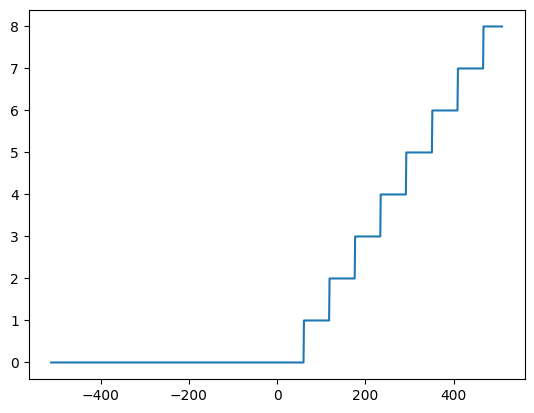

In [3]:
f_naive = fhe.compiler({"x": "encrypted"})(f)

circuit_naive = f_naive.compile(inputset)

naive_res = plot(circuit_naive)

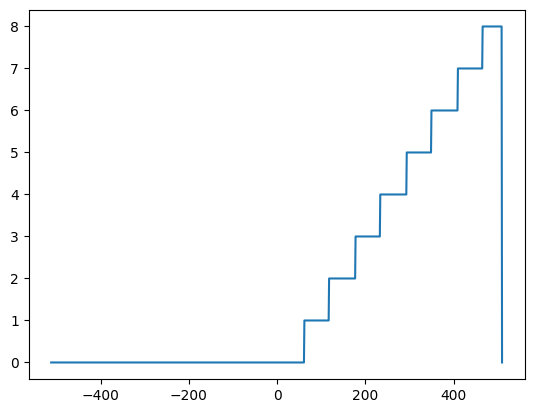

In [4]:
rounding = InsertRounding(8, overflow_protection=True)
pre_proc_round = [rounding]
cfg_round = Configuration(additional_pre_processors=pre_proc_round)

f_round = fhe.compiler({"x": "encrypted"})(f)

circuit_round = f_round.compile(inputset, configuration=cfg_round)

round_res = plot(circuit_round)

In [5]:
print(circuit_round.graph.format())

%0 = x                                                                                                   # EncryptedScalar<int10>        ∈ [-234, 282]
%1 = round_bit_pattern(%0, lsbs_to_remove=2, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int10>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint3>        ∈ [0, 4]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int9>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 1.1                              # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 2.2                              # ClearScalar<float64>
         %5 = subtract(%3, %4)                 # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5,

COUCOU
subgraph_input_shape=(517,)
subgraph_inputs.shape=(517,)
Added rounding node


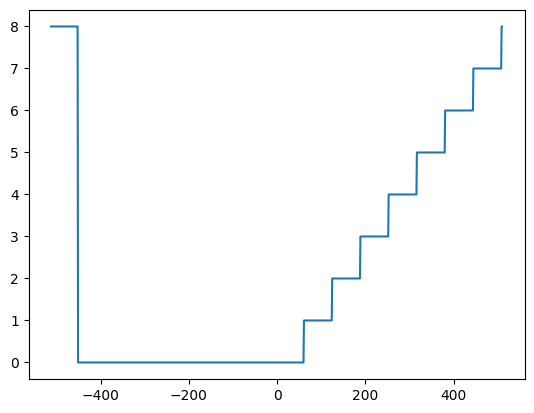

In [6]:
optim = TLUDeltaBasedOptimizer(overflow_protection=True,)
pre_proc_optim = [optim]
cfg_optim = Configuration(additional_pre_processors=pre_proc_optim)

f_optim = fhe.compiler({"x": "encrypted"})(f)

circuit_optim = f_optim.compile(inputset, configuration=cfg_optim)

optim_res = plot(circuit_optim)

In [7]:
print(circuit_optim.graph.format())

%0 = x                                                                                                          # EncryptedScalar<int10>        ∈ [-234, 282]
%1 = 61                                                                                                         # ClearScalar<uint6>
%2 = subtract(%0, %1)                                                                                           # EncryptedScalar<int10>        ∈ [-295.0, 221.0]
%3 = 16384                                                                                                      # ClearScalar<uint15>
%4 = multiply(%2, %3)                                                                                           # EncryptedScalar<int24>        ∈ [-4833280.0, 3620864.0]
%5 = 524288                                                                                                     # ClearScalar<uint20>
%6 = subtract(%4, %5)                                                                                        

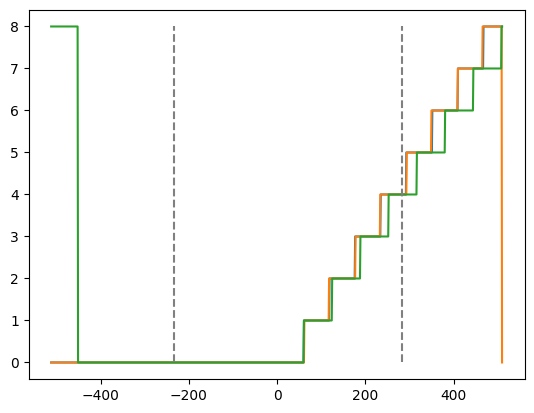

In [12]:
plt.plot(full_range, naive_res,)
plt.plot(full_range, round_res,)
plt.plot(full_range, optim_res,)
plt.vlines(input_range, np.min(naive_res), np.max(naive_res), color="grey", linestyle="--")